<div >
<img src = "figs/ans_banner_1920x200.png" />
</div>

# Estimación de Densidades para el Análisis de Puntos Calientes. Fundamentos Teóricos.

Este *cuaderno* trata sobre la estimación de funciones de densidades que son instrumentales para el Análisis de Puntos Calientes. Los objetivos del *cuaderno* son: que usted reconozca los fundamentos teóricos de la  estimación de densidad de kernel para que sea capaz de identificar sus características, funcionamiento, y de cómo implementarlo.


**NO** es necesario editar el archivo o hacer una entrega. Sin embargo, los ejemplos contienen celdas con código ejecutable (`en gris`), que podrá modificar  libremente. Esta puede ser una buena forma de aprender nuevas funcionalidades del *cuaderno*, o experimentar variaciones en los códigos de ejemplo.

## Introducción

El análisis de puntos calientes es una técnica de mapeo y análisis espacial interesada en la identificación de agrupamientos de fenómenos espaciales. En otras palabras, los puntos calientes son áreas donde hay más concentración de puntos de datos, y el análisis de puntos calientes es el proceso de encontrar estas áreas. 

Para ilustrar este tipo de análisis, imaginemos el caso donde nos contratan para analizar la distribución de crímenes de la ciudad de Chicago. Para poder hacer frente a los delitos y asignar los recursos policiales de la mejor manera es importante tener un buen conocimiento de dónde se encuentran los incidentes y potencialmente hacia dónde se mueven. La siguiente figura ilustra cuatro puntos calientes en la ciudad: uno pequeño en la parte norte, otro en la "magnificent mile" en el centro, y dos más pronunciados en el sur cerca de Hyde Park, y en el oeste en las comunidades de Austin y Lawndale.



<div style="max-width:300px">
<img src = "figs/densidad_bivariada_chicago.png" />
</div>


El análisis de puntos de puntos calientes representados a través de mapas de calor, como el mostrado arriba,  suele ser muy popular debido a que resulta muy fácil visualizar e interpretar los resultados. Este tipo de análisis se hace por lo general utilizando métodos que intentan estimar la función de densidad de los datos. El principal algoritmo que suele utilizarse es el conocido como estimación de densidad de kernel, y en este *cuaderno* nos centraremos en estudiar los detalles de la misma. 


## Funciones de densidad  de probabilidad 

Antes de profundizar en la  estimación de densidad de kernel, es importante recordar a qué nos referimos cuando hablamos de función de densidad de probabilidad ($pdf$, por sus siglas en inglés). La función de densidad de probabilidad describe el comportamiento de una variable aleatoria continua. Es decir, expresa la  probabilidad de que la variable aleatoria tome algún rango de valores. 

Posiblemente la función de densidad más popular en estadística es la distribución normal estándar, que es simplemente la distribución normal centrada en cero con una desviación estándar igual a uno:


<div style="max-width:400px">
<img src = "figs/normal.png" />
</div>

Recordemos también que la función de densidad de una variable es:

   1. Una función no negativa para todo valor de $X$, por ejemplo, $f(x)>0$ $\forall x$
   2. El área total bajo la curva es 1, por ejemplo, $\int_{-\infty}^{\infty} f(x) dx=1$
   3. La probabilidad de que $x$ tome valores en el intervalo $[a,b]$ es el área bajo la curva de ese intervalo, es decir, $Pr(a\leq x \leq b]= \int_a^b f(x) dx$
   
   
Sin embargo, cuando analizamos datos, en lugar de contar con la función de densidad, contamos simplemente con los valores de muestra recolectados aleatoriamente. La intuición es que estos provienen de una población cuya distribución se desconoce. 

La idea entonces es utilizar algún procedimiento de aprendizaje no supervisado para hacer "ingeniería reversa", es decir, tratar de recobrar la función de densidad de probabilidad de la cual surgió esta muestra. Por ejemplo, en este cuaderno estudiaremos la  estimación de densidad de kernel.

## Estimación de densidad de kernel

En estadística, la estimación de densidad de kernel es una forma no paramétrica de estimar la función de densidad de probabilidad de una variable aleatoria. Es decir, una forma de hacer "ingeniería reversa": dado los valores ${\ x_1, \ldots, x_n}$ buscamos recobrar la función de densidad $f(x)$ que le dió origen.

### Histogramas

Para fijar conocimientos, comencemos con una aproximación discreta. Para ello, utilizamos el histograma que nos permite representar la distribución de datos unidimensionales. Recordemos que para crear un histograma tenemos que seguir los siguientes pasos:

1. Identificar el rango de valores observados, del más pequeño al más grande.
2. Dividir el rango en intervalos de igual tamaño (bins).
3. Contar el número de observaciones que caen dentro cada intervalo.

Con estos datos, los representamos en una gráfica de barras, donde la altura de la barra para cada intervalo representa el número de observaciones en ella. Para aproximar la densidad re-escalamos la altura de las barras para que el área total sea uno.

La idea subyacente es que este estimador de densidad asigna el mismo valor de densidad a cada uno de los puntos del intervalo.


Grafiquemos entonces el histograma de los tiempo de espera entre erupción del geyser "Old Faithful" ubicado en el parque Yellowstone en Wyoming, USA. Estos datos surgen del artículo de Azzalini y Bowman (1990) disponibles públicamente. Comencemos cargando los datos:

In [1]:
#Cargamos las librerías a utilizar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Cargamos los datos:
geyser = pd.read_csv('data/geyser.csv')
geyser.head()

,tiempos de espera
0,79
1,54
2,74
3,62
4,85


Utilicemos la función `plt.hist` para representar el histograma con 20 intervalos (`bins`):

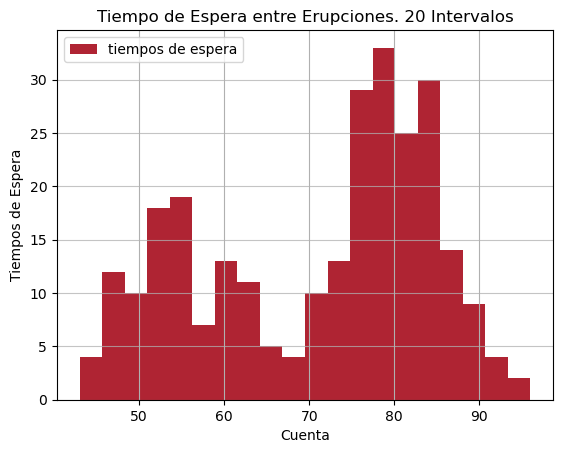

In [2]:
geyser.plot.hist(grid=True, bins=20, color='#af2433')
plt.title('Tiempo de Espera entre Erupciones. 20 Intervalos')
plt.xlabel('Cuenta')
plt.ylabel('Tiempos de Espera')
plt.grid(axis='y', alpha=0.75)

Vemos entonces que pareciera que surge una distribución bimodal de los tiempos entre erupciones. Sin embargo, uno de los principales inconvenientes de los histogramas es que depende del número de intervalos (bins) que utilicemos. Por ejemplo si usamos 10 intervalos y no 20, vemos una distribución unimodal:

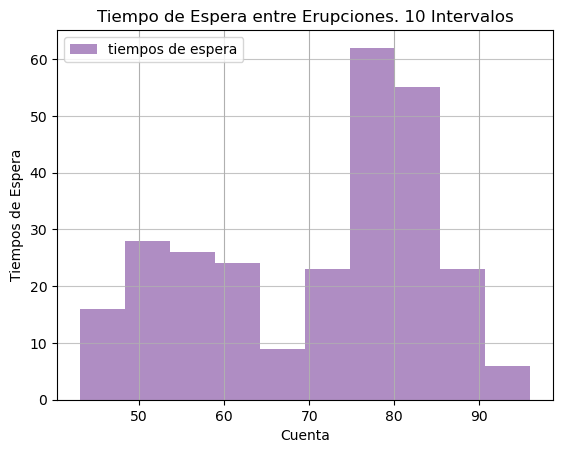

In [3]:
geyser.plot.hist(grid=True, bins=10, color='#af8dc3')
plt.title('Tiempo de Espera entre Erupciones. 10 Intervalos')
plt.xlabel('Cuenta')
plt.ylabel('Tiempos de Espera')
plt.grid(axis='y', alpha=0.75)

Si por el contrario, especificamos 60 intervalos, la interpretación vuelve a cambiar:

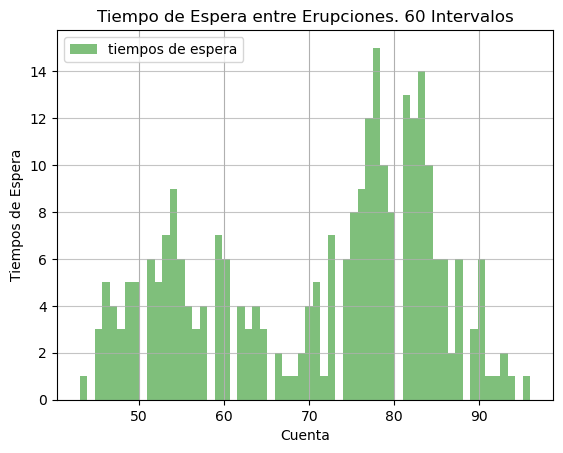

In [4]:
geyser.plot.hist(grid=True, bins=60, color='#7fbf7b')
plt.title('Tiempo de Espera entre Erupciones. 60 Intervalos')
plt.xlabel('Cuenta')
plt.ylabel('Tiempos de Espera')
plt.grid(axis='y', alpha=0.75)

Esta limitación se acentúa cuando tenemos muy pocas observaciones. Por ejemplo, supongamos que tenemos 10 observaciones que surgen de una distribución normal. Querríamos entonces que el histograma refleje esta distribución:

Text(0.5, 1.0, '30 Intervalos')

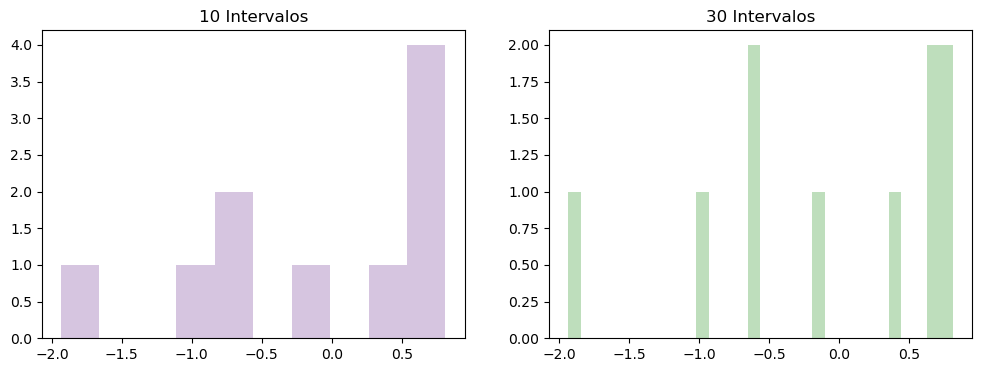

In [5]:
# 10 Datos simulados de una N(0,1)
simulac= np.random.normal(loc=0, scale=1, size=10)


fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12,4))
axs[0].hist(simulac, bins=10, color="#af8dc3", alpha=0.5)
axs[0].set_title('10 Intervalos')
axs[1].hist(simulac, bins=30, color="#7fbf7b", alpha=0.5)
axs[1].set_title('30 Intervalos')


Vemos entonces en este caso extremo, que el histograma no aproxima bien la verdadera distribución subyacente.

### Estimación de densidad de kernel


Como vimos anteriormente, el histograma puede que no logre una representación muy fiel de la distribución subyacente. Esto se debe a que al asignar el mismo valor de densidad a cada punto del intervalo, genera una estimación escalonada y poco suave. La estimación de densidad de kernel (KDE en inglés) expande la idea del histograma, donde si dos observaciones están cerca, esto implica que hay mayor densidad, pero lo hace de forma tal que las contribución a la densidad sea suave y continua.

La estimación de densidad de kernel se conoce entonces como un algoritmo de suavizado porque una curva se dibuja sobre los datos de la muestra, que, si los datos pertenecen a una muestra representativa, puede ser una buena estimación de la verdadera función de densidad de la población. Dicho de otra manera, la estimación de densidad de kernel tiene como objetivo eliminar el ruido inherente a los datos muestrales.

Podemos entonces ver cómo lo hace usando la librería `seaborn` y la función `histplot`. Volvemos nuevamente a graficar la distribución de los datos con 10 intervalos, pero solapamos la estimación KDE. Notemos que la estimación ahora es más suave y continua.

<Axes: ylabel='Count'>

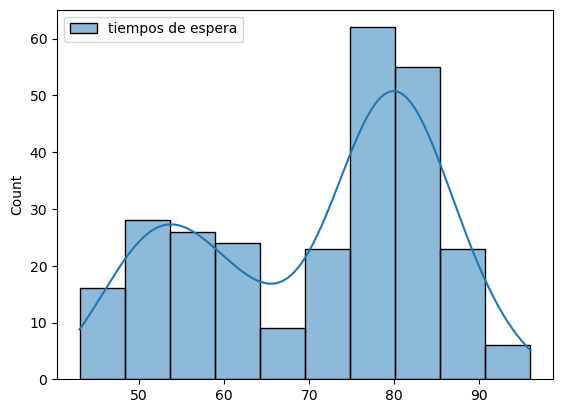

In [6]:
import seaborn as sns

sns.histplot(geyser, multiple="layer", kde=True)

La ventaja de utilizar KDE es que sólo es necesario el supuesto de que existe una verdadera distribución subyacente. Formalmente, podemos definir el método de la siguiente manera: 

Sean $(x_1, x_2, \cdots, x_n)$ muestras independientes e idénticamente distribuidas, extraídas de alguna distribución univariada con una densidad desconocida $f$ en cualquier punto dado $x$. Nos interesa estimar la forma de esta función $f$ y el estimador de la densidad de kernel toma la forma de:

$$\hat{f_h}(x)=\frac{1}{nh}\sum_{i=1}^nK\left(\frac{x-x_i}{h}\right)$$

Donde $K$ es una función no negativa llamada kernel y $h > 0$ es un parámetro de suavización llamado ancho de banda. 

Esta, entonces, genera una densidad estimada utilizando datos de muestra y dos parámetros conocidos: el ancho de banda y la función de kernel. Es decir, KDE se reduce a elegir adecuadamente estos dos parámetros.

### El ancho de banda 	

El parámetro más importante en la estimación de densidad de kernel es el ancho de banda, y no debemos sobre-estimar su impacto en la calidad de la estimación ya que es el valor que determina cuan suave es la estimación.

Si el ancho de banda es bajo, la densidad estimada tendrá un suavizado limitado, lo que quiere decir que la densidad va a capturar todo el ruido de los datos de la muestra. Por el contrario, si el ancho de banda es alto, la densidad estimada será muy suave, omitiendo las características de la densidad real.

Formalmente, en la elección del ancho de banda entra en juego el "dilema" (*trade-off*) sesgo-varianza, que queda claro cuando vemos la expresión del error cuadrático medio (MSE). Entonces:

\begin{align}
  MSE (\hat{f}(x)) = \left( Sesgo (\hat{f}(x))\right)^2 + Var (\hat{f}(x)) 
\end{align}

La expresión aproximada en $x_o$ está dada por 

\begin{align}
  Sesgo [\hat{f} (x_o)] \approx \frac{h^2}{2}  f''(x_o ) \int_{-\infty}^\infty K(\phi) \phi^2  d\phi   
\end{align}

Mientras que la varianza asintótica está dada aproximadamente por:

\begin{align}
   Var [\hat{f} (x_o)] \approx \frac{1}{n\times h}  f(x_o ) \int_{-\infty}^\infty K^2(\phi)   d\phi   
\end{align}

Vemos entonces que a medida que $h\rightarrow 0$ el sesgo disminuye, toda la expresión tiende a cero, pero al mismo tiempo la varianza tiende a infinito. De la misma forma, si $h$ aumenta, el sesgo aumenta, y la varianza tiende a disminuir. Claramente estas expresiones dependen de otras cosas como ser la densidad verdadera, la curvatura de la misma y el kernel elegido. Sin embargo veremos que este parámetro es el más importante a la hora de estimar. Para ilustrarlo veamos un ejemplo en `Python`.

#### Efecto del valor de ancho de banda en `Python`.


En este ejemplo, ajustaremos nueve modelos diferentes con nueve valores de ancho de banda diferentes a datos ficticios de los cuáles conocemos la verdadera distribución. 

Primero comenzamos cargando las librerías necesarias que nos faltan en el cuaderno y creamos algunos datos de muestra (`vals`) mezclando tres distribuciones normales. Además de los datos de muestra, definamos la curva de densidad real (`true_density`) y el rango sobre el cual se trazarán los datos (`x_vec`):

In [7]:
#Cargamos las librerías restantes a utilizar
import scipy.stats
import sklearn.model_selection
from sklearn.neighbors import KernelDensity

Notemos que importamos de `sklearn.neighbors` la función `KernelDensity` que utilizaremos para realizar la KDE de nuestros datos. Esta función toma dos argumentos principales:
   
   - `bandwidth`: ancho de banda
   - `kernel`: la función de kernel a utilizar, que toma como default el kernel gaussiano o la distribución normal. Más adelante discutiremos más sobre este parámetro.
 
 

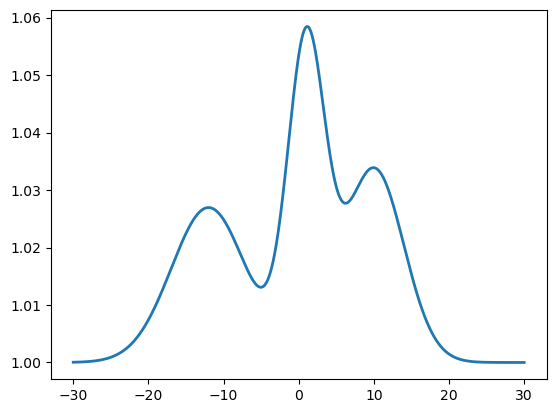

In [8]:
# Generamos el vector x sobre el cual estimamos la densidad
x_vec = np.linspace(-30, 30, 10000)[:, np.newaxis]

# Generamos una muestra aleatoria que es la mezcla de 3 distribuciones normales

np.random.seed(42)
vals = np.concatenate((
    np.random.normal(loc=1, scale=2.5, size=500), 
    np.random.normal(loc=10, scale=4, size=500), 
    np.random.normal(loc=-12, scale=5, size=500)
))[:,  np.newaxis]

true_density = (
    (1 / 3) * scipy.stats.norm(1, 2.5).pdf(x_vec[:, 0]) + 
    (1 / 3) * scipy.stats.norm(10, 4).pdf(x_vec[:, 0]) +
    (1 / 3) * scipy.stats.norm(-12, 5).pdf(x_vec[:, 0])
)

#Graficamos la densidad
plt.plot(x_vec[:, 0], np.exp(true_density), '-', linewidth=2)
plt.show()

A continuación definamos una lista de tuplas que nos permita crear un gráfico para comparar los efectos del ancho de banda. Para ello, cada tupla contiene los índices de fila y columna del sub-gráfico respectivo, y el valor del ancho de banda que vamos a utilizar en ese sub-gráfico. Es importante destacar, que los anchos de banda aquí elegidos han sido escogidos al azar para ilustrar el "dilema" (*trade-off*) discutido anteriormente. En la siguiente sección  discutiremos estrategias para la elección del ancho de banda.

In [9]:
position_bandwidth_vec = [
    (0, 0, 0.1), (0, 1, 0.4), (0, 2, 0.7), 
    (1, 0, 1.0), (1, 1, 1.3), (1, 2, 1.6), 
    (2, 0, 1.9), (2, 1, 2.5), (2, 2, 5.0)
]
position_bandwidth_vec

[(0, 0, 0.1),
 (0, 1, 0.4),
 (0, 2, 0.7),
 (1, 0, 1.0),
 (1, 1, 1.3),
 (1, 2, 1.6),
 (2, 0, 1.9),
 (2, 1, 2.5),
 (2, 2, 5.0)]

Ahora estamos en posición de crear nueve gráficas, cada una con un valor de ancho de banda diferente. El primer gráfico, con el índice de (0, 0), tendrá el valor de ancho de banda más bajo y el último gráfico, con el índice de (2, 2), tendrá el más alto. Estos valores no son los valores absolutos de ancho de banda más bajos o más altos posibles, sino que son sólo el mínimo y el máximo de la lista definida en el paso anterior. Los invito a que prueben con otros anchos de banda.

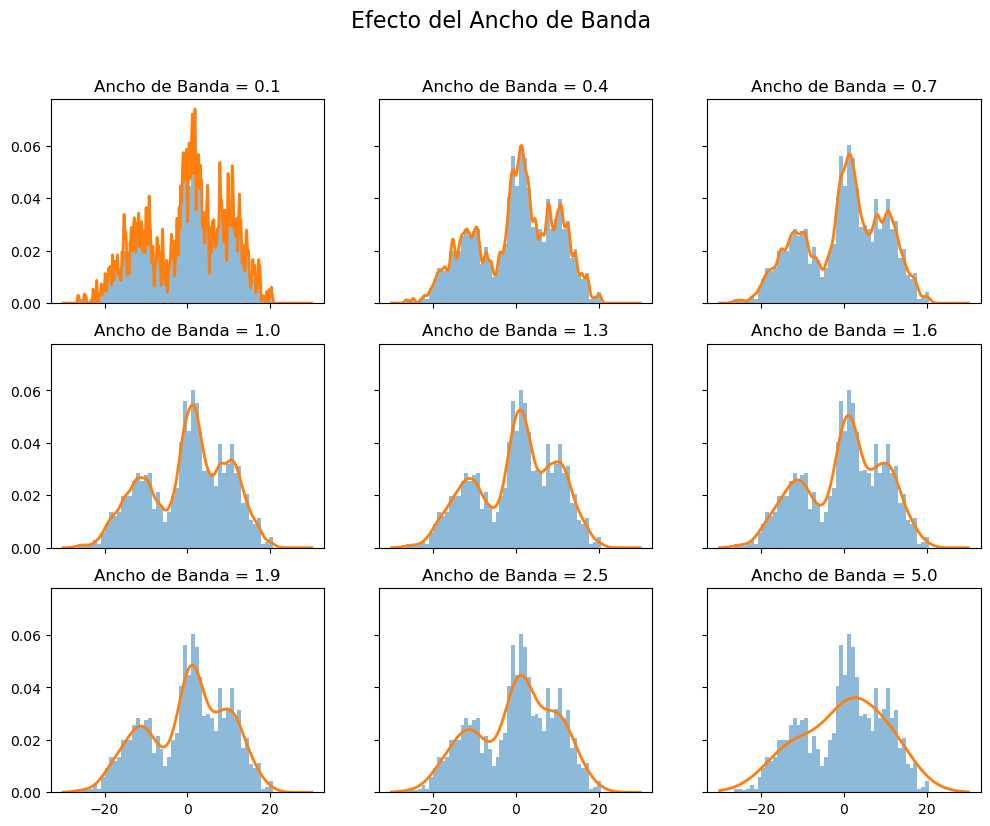

In [10]:
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(12, 9))
fig.suptitle('Efecto del Ancho de Banda', fontsize=16)

for r, c, b in position_bandwidth_vec:
    kde = KernelDensity(bandwidth=b).fit(vals)
    log_density = kde.score_samples(x_vec)

    ax[r, c].hist(vals, bins=50, density=True, alpha=0.5)
    ax[r, c].plot(x_vec[:, 0], np.exp(log_density), '-', linewidth=2)
    ax[r, c].set_title('Ancho de Banda = {}'.format(b))
plt.show()

De las gráficas anteriores podemos observar que, claramente, si el ancho de banda es muy pequeño como en el primer gráfico la densidad estimada se ajusta a cada uno de los puntos, capturando más "ruido" que "señal". Por otro lado, la curva de densidad estimada en el noveno sub-gráfico (donde el ancho de banda es 5) no  ajusta  bien los datos, no es capaz de distinguir la tri-modalidad de la distribución subyacente. En general, podemos ver que a medida que aumentan los valores de ancho de banda, la densidad estimada se va suavizando hasta que se ajustan bien  los datos. Visualmente, esto parece suceder alrededor de un ancho de banda de 1,6. Pasado esto, se suaviza demasiado y la estimación se vuelve más sesgada.

Nuestro próximo paso es diseñar un algoritmo para identificar el mejor ancho de banda posible para que la densidad estimada sea más precisa y confiable.

#### Elección de anchos de banda

Existen dos enfoques estándar para elegir el valor del ancho de banda, un enfoque teórico, que usa como referencia una distribución estándar, y uno pragmático usando validación cruzada. 

El primer enfoque, toma como referencia una distribución conocida y encuentra el ancho de banda ideal. Estos tipos de métodos se suelen conocer como métodos plug-in y suelen ser generalmente mucho más rápidos de implementar, más simples de codificar y más fáciles de explicar. La regla de Silverman y la regla de Scott son los métodos plug-in más populares:

   - Regla de Scott: $h \approx 1.06⋅\hat{\sigma} n^{−1/5}$. Esta regla surge de asumir que la distribución subyacente es normal, y utiliza la varianza estimada a partir de los datos. La librería `seaborn` por ejemplo utiliza esta regla de forma predeterminada como método para determinar el valor del ancho de banda.

   - Regla de Silverman: $h \approx 0.9 min \left\{\hat{\sigma}, \frac{IQR}{1.35}\right\} n^{−1/5}$. Esta regla es similar a la de Scott, pero remplaza la varianza estimada con $min \left\{\hat{\sigma}, \frac{IQR}{1.35}\right\}$, para obtener una estimación más robusta de la varianza de los datos y que suele funcionar mejor si la distribución subyacente es moderadamente bimodal.

Si bien estos métodos son muy rápidos, tienen el limitante de funcionar bien sólo cuando la función de densidad real es aproximadamente normal.

El segundo enfoque es el de validación cruzada. Este método es computacionalmente más costoso, pero más robusto para encontrar el mejor ancho de banda. La idea es similar a la vista en aprendizaje supervisado y consiste en buscar valores de ancho de banda a partir de una grilla predefinida, de forma tal que maximice una métrica preestablecida, en este caso, la log-verosimilitud. La idea por detrás es utilizar la verosimilitud para juzgar cuán adecuado es el ajuste del modelo estadístico. 

Para cada posible ancho de banda $h$, vamos a proceder con validación cruzada en $k$ partes. Es decir, iniciamos separando aleatoriamente la muestra en $k$ partes. $k-1$ partes se emplean para ajustar el modelo y la $k$-ésima parte para ajustar el modelo. En esta iteración calculamos:

\begin{align}
CV_k(h) = \frac{1}{n} \sum_{i=1}^n \log \hat{f}_{-k}(X_k)
\end{align}

Donde $\hat{f}_{-k}$ es la densidad estimada construida a partir de todos los puntos, excepto aquellos en la partición $k$. $CV_k(h)$ es entonces el score de evaluar esta estimación en la partición $k$. Este proceso lo repetimos $k$ veces utilizando un grupo distinto para evaluar el modelo en cada iteración. El proceso genera $k$ estimaciones de $CV_k(h)$ y usamos el promedio como estimación final de la calidad de ajuste. Es importante agregar que, cuando se dispone de pocos datos, es conveniente utilizar  *leave out crossvalidation* . 

Implementemos ahora este enfoque para encontrar el valor del ancho de banda de los datos simulados anteriormente. Una de las ventajas de este método es que está disponible en `Scikit-learn`.

Sin embargo, antes de proceder notemos que `KernelDensity` retorna la log-verosimilitud por defecto y es sencillo obtener la expresión $\frac{1}{n} \sum_{i=1}^n \log \hat{f}(X_i)$ (notemos además que utilizamos estos valores para nuestros gráficos anteriores). Por ejemplo:

In [11]:
kde = KernelDensity(bandwidth=1.6).fit(vals)
np.mean(kde.score_samples(x_vec))

-5.8977912882427805

Comenzamos entonces creando una grilla de los posibles anchos de banda a utilizar:

In [12]:
bandwidths = 10 ** np.linspace(-1, 1, 100)
bandwidths[0:10]

array([0.1       , 0.10476158, 0.10974988, 0.1149757 , 0.12045035,
       0.12618569, 0.13219411, 0.13848864, 0.14508288, 0.15199111])

Ahora entonces podemos utilizar la función `GridSearchCV` de la librería `Scikit-learn`, donde especificamos como estimador la función `KernelDensity`, que sabemos retorna el score que queremos por defecto. Especificamos también la grilla de los anchos de banda potenciales, y que vamos a utilizar validación cruzada en 10 partes.

In [13]:
from sklearn.model_selection import GridSearchCV

In [14]:
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': bandwidths},
                    cv=10)
grid.fit(vals)

GridSearchCV(cv=10, estimator=KernelDensity(),
             param_grid={'bandwidth': array([ 0.1       ,  0.10476158,  0.10974988,  0.1149757 ,  0.12045035,
        0.12618569,  0.13219411,  0.13848864,  0.14508288,  0.15199111,
        0.15922828,  0.16681005,  0.17475284,  0.18307383,  0.19179103,
        0.2009233 ,  0.21049041,  0.22051307,  0.23101297,  0.24201283,
        0.25353645,  0.26560878,  0.27825594,  0.29150531,  0.30538555,
        0.319926...
        2.05651231,  2.15443469,  2.25701972,  2.36448941,  2.47707636,
        2.59502421,  2.71858824,  2.84803587,  2.98364724,  3.12571585,
        3.27454916,  3.43046929,  3.59381366,  3.76493581,  3.94420606,
        4.1320124 ,  4.32876128,  4.53487851,  4.75081016,  4.97702356,
        5.21400829,  5.46227722,  5.72236766,  5.9948425 ,  6.28029144,
        6.57933225,  6.8926121 ,  7.22080902,  7.56463328,  7.92482898,
        8.30217568,  8.69749003,  9.11162756,  9.54548457, 10.        ])})

Nos queda entonces por obtener el ancho de banda que minimiza la log-verosimilitud:

In [15]:
best_bandwidth = grid.best_params_["bandwidth"]

print(
    "Mejor Ancho de Banda: {}"
    .format(best_bandwidth)
)

Mejor Ancho de Banda: 1.6297508346206444


Finalmente grafiquemos el histograma de los datos, la verdadera densidad (en gris) y la densidad estimada con el mejor ancho de banda (KDE):

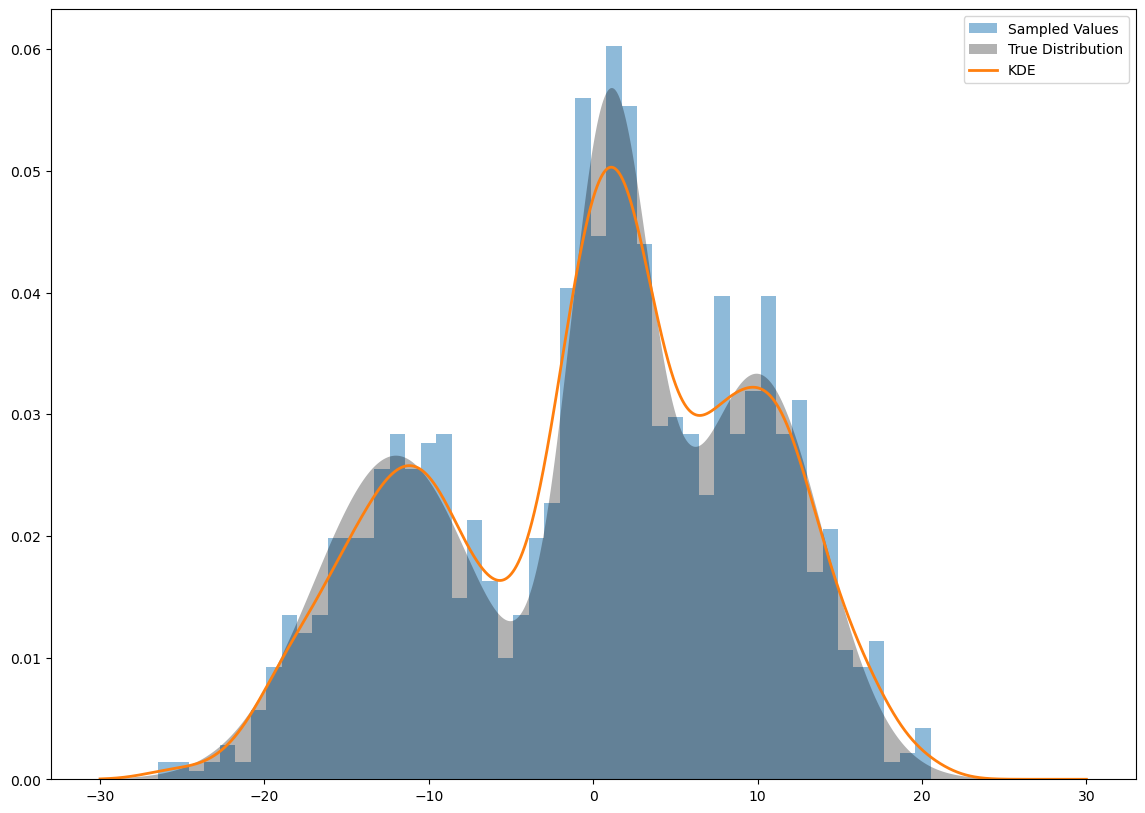

In [16]:
fig, ax = plt.subplots(figsize=(14, 10))

ax.hist(vals, bins=50, density=True, alpha=0.5, label='Sampled Values')
ax.fill(x_vec[:, 0], true_density, fc='black', alpha=0.3, label='True Distribution')

log_density = np.exp(grid.best_estimator_.score_samples(x_vec))
ax.plot(x_vec[:, 0], log_density, '-', linewidth=2, label='KDE')

ax.legend(loc='upper right')
plt.show()

La gráfica muestra cómo se superponen la densidad real y la estimada óptima. La densidad estimada no está ni sobre suavizada, ni sobre ajustada y es capaz de capturar los 3 grupos subyacentes.

### Función de kernel


En toda esta discusión, sin embargo omitimos discutir qué es y qué papel juega la función de kernel. Como vimos, el otro parámetro importante en la estimación es esta función. 

Formalmente el kernel es una función no negativa que controla la forma de la densidad y tiene ciertas propiedades deseables: 

1. Simetría: $K(u)=K(-u)$.
2. Normalizada de modo que $\int_{-\infty}^\infty K(u) du = 1$.
3. Monótona decreciente tal que $K'(u)<0$ cuando $u>0$.
4. Valor esperado igual a 0: $E[K]=0$.

Intuitivamente esta función sirve como ponderador de la contribución de cada dato. A diferencia del histograma donde el estimador asigna el mismo valor de densidad a cada uno de los puntos del intervalo, KDE asigna en función del kernel.

Para ilustrar la idea supongamos que tenemos 4 puntos:

(-0.05, 1.0)

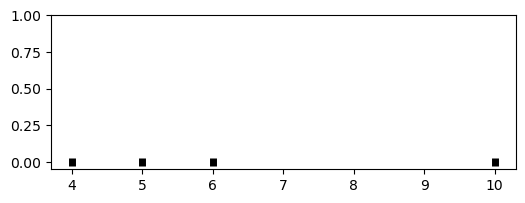

In [17]:
X = np.array([4, 5, 6, 10])
fig, ax = plt.subplots(figsize=(6,2))
ax.plot(X, np.full_like(X, 0.05), '|k', markeredgewidth=5)
ax.set_ylim(-0.05,1)

La función de kernel va a centrar la función elegida sobre cada uno de los puntos. Usemos en este ejemplo el kernel gaussiano, y comencemos dibujando esta distribución (la gaussiana) sobre el primer punto:

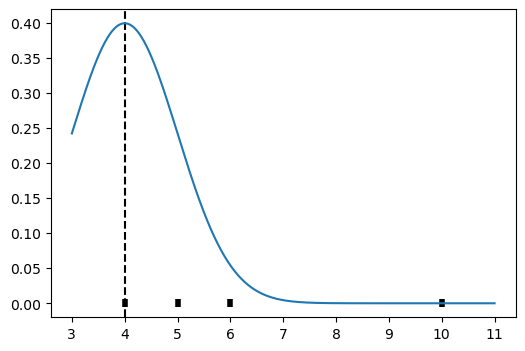

In [18]:
from scipy import stats

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(X, np.full_like(X, 0), '|k', markeredgewidth=4)

Xgrid = np.linspace(min(X) - 1, max(X) + 1, num=500)


dens = stats.norm.pdf(Xgrid, loc=X[0], scale=1)
ax.axvline(x=X[0], linestyle='--', color='black')
ax.plot(Xgrid, dens)

La contribución de cada punto a la estimación, ahora está dada por la función de densidad en ese punto. La contribución de 4 será:

In [19]:
stats.norm.pdf(4, loc=X[0], scale=1)

0.3989422804014327

La de 5: 

In [20]:
stats.norm.pdf(5, loc=X[0], scale=1)

0.24197072451914337

Y la de 10:

In [21]:
stats.norm.pdf(10, loc=X[0], scale=1)

6.075882849823286e-09

Notemos que esta es decreciente, y que todos los puntos contribuyen, a diferencia del histograma donde sólo contribuyen aquellos dentro del intervalo. Esto necesitamos hacerlo para todos los puntos de la muestra:

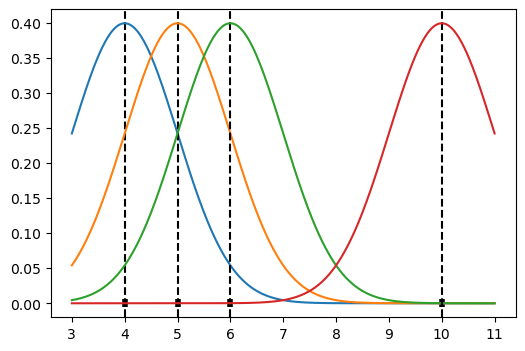

In [22]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(X, np.full_like(X, 0), '|k', markeredgewidth=4)

Xgrid = np.linspace(min(X) - 1, max(X) + 1, num=500)

for x in X:
    dens = stats.norm.pdf(Xgrid, loc=x, scale=1)
    ax.axvline(x=x, linestyle='--', color='black')
    ax.plot(Xgrid, dens)

La estimación final es el promedio de las densidades a cada punto. Entonces, en 4 la estimación es: 

In [23]:
(1/4)*(stats.norm.pdf(4, loc=X[0], scale=1)+stats.norm.pdf(4, loc=X[1], scale=1)+stats.norm.pdf(4, loc=X[2], scale=1)+stats.norm.pdf(4, loc=X[3], scale=1))

0.1737259943774117

O gráficamente:

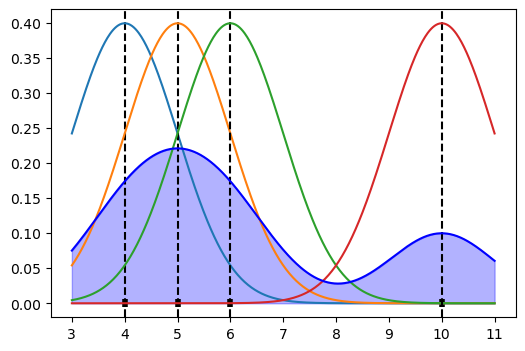

In [24]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(X, np.full_like(X, 0), '|k', markeredgewidth=4)

Xgrid = np.linspace(min(X) - 1, max(X) + 1, num=500)

sum = np.full_like(Xgrid, 0)
for x in X:
    dens = stats.norm.pdf(Xgrid, loc=x, scale=1)
    sum = sum + dens
    ax.axvline(x=x, linestyle='--', color='black')
    ax.plot(Xgrid, dens)
    
sum = sum / len(X)
ax.plot(Xgrid, sum, color='b')
ax.fill_between(Xgrid, sum, alpha=0.3, color='b');


La densidad final estimada para 4 es 0.17.

En la literatura se suelen utilizar diferentes funciones kernel: gaussiana, Epanechnikov, uniforme, exponencial, entre otras:

- Gaussiana: La función de peso toma la forma de campana, se utiliza la normal estándar, es decir con media cero y varianza 1, $N(0,1)$:

\begin{align}
K\ \left(x;h\right) = \frac{1}{\sqrt{2\pi}} \exp{ \left(-\frac{x^2}{2}\right)}\ 
\end{align}

y su soporte es $\mathbb R$. Gráficamente:

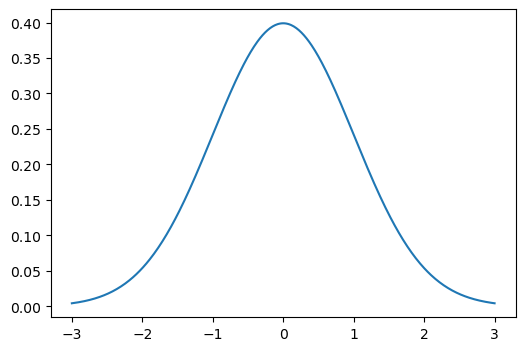

In [25]:
fig, ax = plt.subplots(figsize=(6,4))

Xgrid = np.linspace(-3, 3, num=500)
dens = stats.norm.pdf(Xgrid, loc=0, scale=1)
ax.plot(Xgrid, dens)

- Epanechnikov: La función de peso toma la forma de montículo:

\begin{align}
K\ \left(x;h\right)= \frac{3}{4} \left( 1-x^2 \right)
\end{align}

y su soporte es $|x|\leq 1$. Este tipo de kernel suele ser muy utilizado por sus buenas propiedades teóricas. Gráficamente:

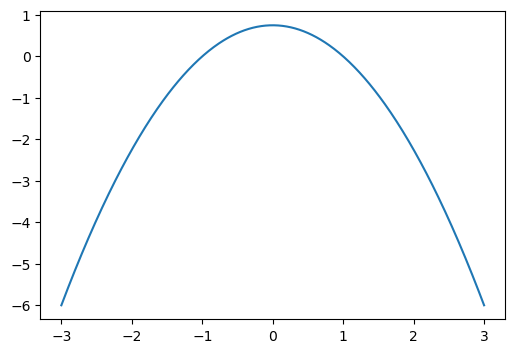

In [26]:
fig, ax = plt.subplots(figsize=(6,4))

Xgrid = np.linspace(-3, 3, num=500)
dens_epa = (3/4)*(1-Xgrid**2)
ax.plot(Xgrid, dens_epa)

- Uniforme o tophat: La función de peso es rectangular, similar al histograma:

\begin{align}
K\ \left(x\right) = \frac{1}{2}
\end{align}

y su soporte es $|x|\leq 1$. Gráficamente:

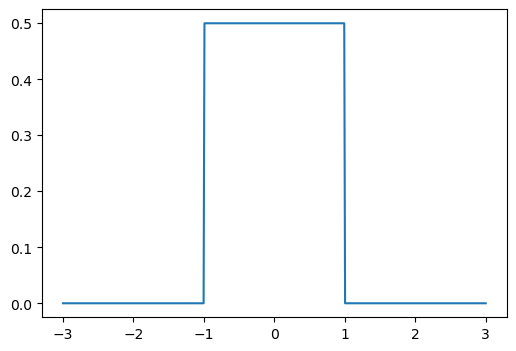

In [27]:
fig, ax = plt.subplots(figsize=(6,4))

Xgrid = np.linspace(-3, 3, num=500)
dens = np.where(abs(Xgrid)<=1,1/2,0)
ax.plot(Xgrid, dens)

- Triangular o linear. La función de pesos toma la forma triangular:

\begin{align}
K\ \left(x\right) = \left( 1- |x|\right)
\end{align}

y su soporte es $|x|\leq 1$. Gráficamente:

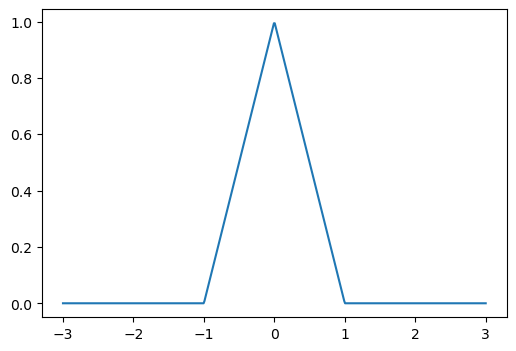

In [28]:
fig, ax = plt.subplots(figsize=(6,4))

Xgrid = np.linspace(-3, 3, num=500)
dens = np.where(abs(Xgrid)<=1,1-abs(Xgrid),0)
ax.plot(Xgrid, dens)

Te invito a que investigues más sobre las distintas funciones de kernel que pueden ser elegidas, [wikipedia](https://en.wikipedia.org/wiki/Kernel_(statistics)) es un buen lugar para comenzar.

#### Efecto de la elección de la función de kernel en `Python`.

Veamos entonces ahora el rol que juega la  elección de la función de kernel en la estimación de la densidad. Al igual que hicimos cuando exploramos el efecto del valor del ancho de banda, mantendremos todos los demás parámetros constantes, usaremos los mismos datos generados en los dos primeros ejercicios y veremos cómo cambia la densidad estimada con la elección de los kernel. 

Comenzamos definiendo nuevamente una lista de tuplas que nos permita crear el gráfico para comparar los efectos de la función de kernel. Cada tupla contiene los índices de fila y columna del sub-gráfico respectivo y el nombre de la función de kernel.


In [29]:
position_kernel_vec = [
    (0, 0, 'gaussian'), (0, 1, 'epanechnikov'), 
    (1, 0, 'tophat'),   (1, 1, 'linear')
]

Con esta lista definida podemos crear cuatro gráficas, cada uno usando una función de kernel diferente para cada uno.  El primer gráfico, con el índice de (0, 0), estimará entonces  usando el kernel gaussiano, el segundo, con índice (0, 1), con el kernel Epanechnikov, el tercer con índice (1,0), con el kernel  uniforme o tophat, y el último utilizará el kernel triangular o linear. (La librería `Scikit-learn` permite especificar otras funciones de kernel y te invito a que las investigues). Para que los resultados sean comparables vamos a utilizar el ancho de banda que mejor ajusta los datos encontrado anteriormente. 

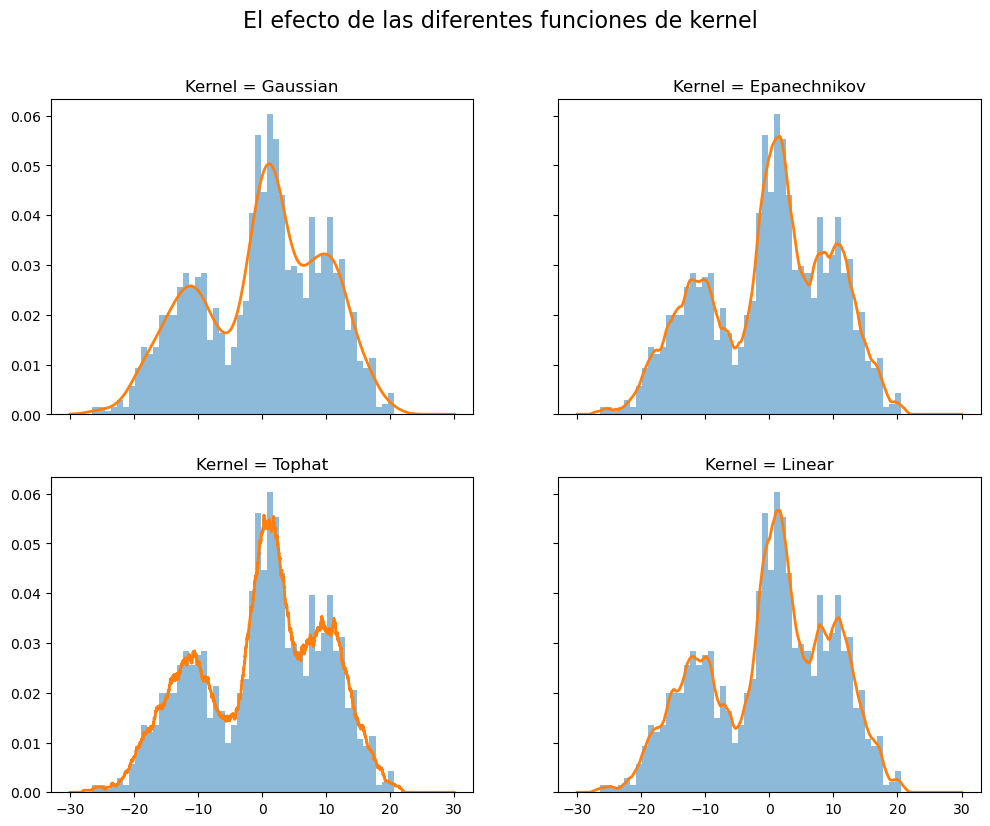

In [30]:

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(12, 9))
fig.suptitle('El efecto de las diferentes funciones de kernel', fontsize=16)

for r, c, k in position_kernel_vec:
    kde = sklearn.neighbors.KernelDensity(
        kernel=k, 
        bandwidth=best_bandwidth
    ).fit(vals)
    log_density = kde.score_samples(x_vec)

    ax[r, c].hist(vals, bins=50, density=True, alpha=0.5)
    ax[r, c].plot(x_vec[:, 0], np.exp(log_density), '-', linewidth=2)
    ax[r, c].set_title('Kernel = {}'.format(k.capitalize()))
plt.show()

De las cuatro funciones de kernel, el kernel gaussiano produjo la densidad estimada más razonable. Sin embargo, observemos que la diferencia entre las densidades estimadas con diferentes kernels es menor que la diferencia entre las densidades estimadas con diferentes valores de ancho de banda. Es decir que las estimaciones son mucho más sensibles a la elección del ancho de banda que al kernel utilizado. Es por esto, además, que no existe la misma preocupación de implementar un procedimiento de validación cruzada como lo hicimos anteriormente. Sin embargo, esto no implica que usted no pueda hacerlo.

## Análisis de puntos calientes y estimación de densidades de kernel bivariadas

Como mencionamos al inicio, en el análisis de puntos de puntos calientes se busca
encontrar áreas donde hay más concentración de puntos de datos, y esto se puede lograr a través de la estimación de densidades.

Sin embargo, cuando los datos son geográficos, nos encontramos en dos dimensiones. Es decir, la frecuencia está ahora determinada por dos variables: longitud y latitud. Entonces, si un par de longitudes y de latitudes específicas  y otros pares cercanos ocurren con alta frecuencia. Entonces la densidad estimada de los datos de la muestra nos va a mostrar que el área alrededor de estos puntos ocurren con alta probabilidad. Es decir, en el mapa de Chicago mostrado anteriormente, los puntos calientes están representados por las densidades estimadas, que marcan áreas de mayor probabilidad de delitos.

Teóricamente podemos usar y extender el mismo principio de la estimación de densidad de kernel univariada estudiada anteriormente para cualquier tipo de densidades. Por ejemplo, para una muestra $x_1,\ldots,x_n \in \mathbb{R}^p$, la KDE de $f$ evaluada en $x \in \mathbb{R}^p$ está definida por:

\begin{align}
\hat{f}(x;H):=\frac{1}{n|H|^{1/2}}\sum_{i=1}^nK\left(H^{-1/2}(\mathbf{x}-\mathbf{x}_i)\right)
\end{align}



donde K es un kernel multivariado, y $H$ es una matriz de tamaño $p\times p$ simétrica y positiva definida, que representa los anchos de banda. Si asumimos que los datos son $iid$, supuesto que usa la mayoría de librerías en `Python`, entonces en el caso bidimensional, esta expresión se resume a:

\begin{align}
    \hat{f}(x,y) = \frac{1}{nh_xh_y}\sum_{i=1}^n K\left(\frac{X_i-x}{h_x}\right)K\left(\frac{Y_i-x}{h_y}\right)
  \end{align}

Notemos que en este caso tenemos que escoger dos anchos de banda, y si se levanta el supuesto $iid$ deberían ser tres, se suma el término fuera de la diagonal en $H$. El supuesto $iid$ es un supuesto que suele utilizarse a menudo ya que si bien estimar todas las entradas de $H$ nos da mejor control sobre la estimación; esto viene con la desventaja de que el número de parámetros a escoger, que en el caso general son $\frac{p(p+1)}{2}$, aumenta a medida que $p$ crece. esto hace que el costo computacional de la selección de parámetros aumente considerablemente. 

### KDE bivariado en `Python`

Veamos ahora cómo podemos hacer para realizar esta estimación bivariada en `Python`. Para ello vamos a utilizar información de  AirBnbs de la ciudad de Austin en Texas, USA. Estos datos fueron recolectados por  [Inside AirBnb](http://insideairbnb.com/about/) y son de uso público. 

Los datos fueron bajados y guardados en la carpeta de `data`. Luego de llamarlos, hacemos la limpieza de una observación atípica de los datos. 

In [31]:
lst = pd.read_csv('data/listings.csv.gz')
lst = lst[["latitude", "longitude"]]

#Existe un airbnb ubicado en una longitud de al rededor de -80 Vamos a eliminar este dato
lst = lst.loc[lst.longitude < -80,].reset_index(drop = True)

 Podemos visualizar la ubicación de los puntos usando [bokeh](https://bokeh.org/) una alternativa util a `folium` cuando el volumen de datos a visualizar es muy grande. [Bokeh](https://bokeh.org/) tiene como contrapartida que requiere ciertos pasos adicionales para poder generar una gráfica. Exploremos entonces estos pasos:
 
 1. El primer requisito es que los datos estén en la proyección Web Mercator:

In [32]:
#Cargamos las librería a utilizar
import geopandas as gpd

# Convertimos el data frame en un `GeoDataFrame` para poder proyectar más facilmente
puntos = gpd.GeoDataFrame(geometry = gpd.points_from_xy(lst.longitude, lst.latitude), crs = "epsg:4326")

# Proyectamos a Web Mercator
puntos = puntos.to_crs(epsg = 3857)


Luego es necesario  poner los datos de forma que [bokeh](https://bokeh.org/) los entienda. Esto requiere tener una columna con la latitud y longitud que extraeremos de la geometría: 

In [33]:

# Necesitamos ahora poner los datos de forma que Bokeh los entienda
# Creamos columnas con la latitud y longitud
puntos['lon'] = puntos.geometry.x
puntos['lat'] = puntos.geometry.y

# Descartamos la geografía
puntos_nogeo = puntos.drop('geometry', axis=1).copy()


El próximo paso es descartar la geometría y convertir el `DataFrame a un `ColumnDataSource` que es la forma que [bokeh](https://bokeh.org/) guarda los datos:

In [34]:
# Ahora podemos convertir el DataFrame en un ColumnDataSource que es la forma que Bokeh guarda los datos
from bokeh.models import ColumnDataSource

# Point DataSource
puntos_bokeh = ColumnDataSource(puntos_nogeo)

Ahora que tenemos nuestro objeto en el formato adecuado, vamos a crear una función para visualizar el mapa con [bokeh](https://bokeh.org/). 

1) Iniciamos importando los módulos necesarios:

In [35]:
from bokeh.plotting import figure, output_notebook, show

2) Indicamos que se va a desplegar dentro de un Jupyter Notebook:

In [36]:
output_notebook() 

Loading BokehJS ...

3) Delimitamos los bordes del mapa, para ello podemos usar los valores máximos y mínimos de las coordenadas a graficar:

In [37]:
# Extraemos los puntos más extremos para definir los límites del mapa
minx, miny, maxx, maxy = puntos.total_bounds
y_range = miny, maxy 
x_range = minx, maxx 

4) Definimos una función para el gráfico base, con estos valores mínimos, tamaño de la gráfica y otras opciones, como ser el color y el tamaño:

In [38]:
def base_plot(tools = 'pan,wheel_zoom,reset', width = 600, height = 400, **plot_args):
    p = figure(tools = tools, width = width, height = height,
        x_range = x_range, y_range = y_range, outline_line_color = None,
        min_border = 0, min_border_left = 0, min_border_right = 0,
        min_border_top = 0, min_border_bottom = 0, **plot_args)

    p.axis.visible = False
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    return p

# Definimos que nuestros puntos tengan color morado (#800080) y sean de tamaño 4
options = dict(line_color = None, fill_color = '#800080', size = 4)

5) Creamos la primer capa con este mapa base. 

In [39]:
# Creamos la primer capa con este mapa base:
p = base_plot()

6) Agregamos una capa con la información geográfica que surge de un proveedor de los servicios de cartografía. Este proveedor será el que visualizará las calles, ríos, parques, nombres de las ciudades, etc. Para ver los proveedores disponibles puede ingresar a https://docs.bokeh.org/en/dev-3.0/docs/user_guide/geo.html#tile-provider-maps

In [40]:
from bokeh.tile_providers import CARTODBPOSITRON, get_provider

tile_provider = get_provider(CARTODBPOSITRON)

p.add_tile(tile_provider)

TileRenderer(id='p1031', ...)

7) Añadimos la capa con las ubicaciones de los airbnb como puntos

In [41]:
p.circle('lon', 'lat', source=puntos_bokeh, **options)

GlyphRenderer(id='p1041', ...)

8) Finalmente, visualizamos nuestro mapa

In [42]:
show(p)

La gráfica muestra que la mayor concentración de Airbnbs está en el centro de la ciudad. Estimemos ahora los puntos calientes usando densidades bivariadas. 

Para ello vamos a usar la librería `seaborn` que permite visualizar fácilmente puntos en una y dos dimensiones, y tiene también métodos de estimación de densidades. Comenzamos usando la función `joinplot` que permite juntar gráficos, en este caso, el gráfico de dispersión de longitud y latitud, junto a los histogramas univariados.


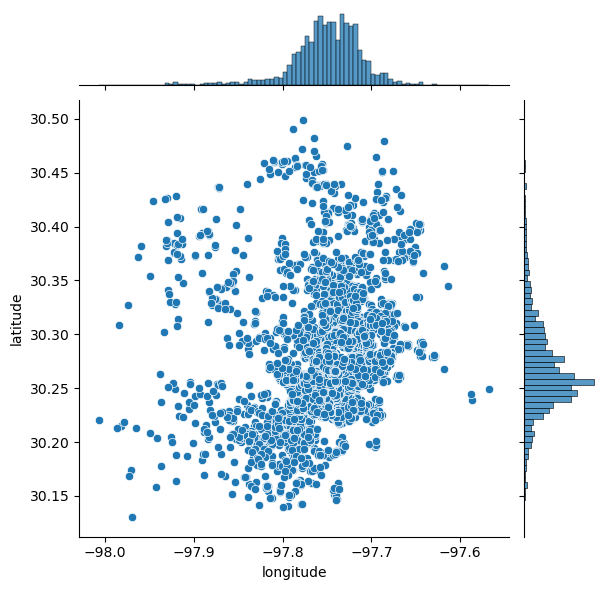

In [43]:
sns.jointplot(data = lst, x = "longitude", y = "latitude")

Esta gráfica confirma la intuición que vimos en el mapa interactivo de [bokeh](https://bokeh.org/) donde veíamos la concentración de Airbnbs en el centro de la ciudad. Note las distribuciones marginales unimodales, reflejando la mayor densidad en el centro de la ciudad.  Una ventaja adicional de `seaborn` es que especificando el tipo (`kind`) igual a `kde` nos permite obtener la estimación bivariada.

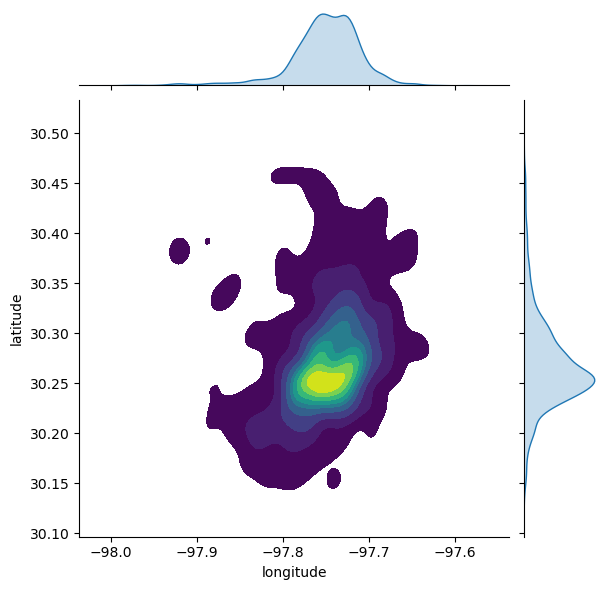

In [44]:
sns.jointplot(data = lst, x = "longitude", y = "latitude", kind="kde", fill = True, cmap = 'viridis')

Note que la estimación refleja el punto caliente del que venimos discutiendo en el centro de la ciudad. Sin embargo, hay que ser cuidadosos ya que vimos la importancia del ancho de banda y en el paso anterior usamos el ancho de banda por defecto de `seaborn`, que es la regla de Scott. Observemos, además, que sólo admite especificar una escala como ancho de banda, que utiliza el kernel gaussiano y no admite otro tipos de función de kernel. Es por todo esto, que si bien es una buena herramienta para iniciar el análisis exploratorio, necesitamos una mejor.

Para ello vamos a utilizar la función [`KDEMultivariate`](https://www.statsmodels.org/dev/generated/statsmodels.nonparametric.kernel_density.KDEMultivariate.html) de la librería `statsmodels`, que nos da más flexibilidad en la estimación. La única desventaja es que por ahora sólo admite el uso de funciones de kernel gaussianas, aunque como vimos anteriormente, la elección de la función de kernel no influye demasiado en la estimación.

Usaremos `seaborn` para ajustar y visualizar el modelo de estimación de densidad de kernel que construimos en los puntos de datos de longitud y latitud. Hay cuatro entradas al modelo que corresponden a los nombres de las dos columnas sobre las que queremos calcular la densidad (es decir, la longitud y la latitud), los datos a los que pertenecen las columnas,y el método de estimación de densidad (es decir, el de estimación de densidad de kernel):

In [45]:
#Cargamos la librería 
import statsmodels.api as sm

Estimamos la función de densidad utilizando como ancho de banda el elegido por validación cruzada `cv_ml` y que ya viene programado en la función.

In [46]:
dens_u = sm.nonparametric.KDEMultivariate(data=lst, var_type='cc', bw='cv_ml')

C:\Users\sonia.olaya\AppData\Local\anaconda\Lib\site-packages\statsmodels\nonparametric\kernel_density.py:158: RuntimeWarning: invalid value encountered in log
  L += func(f_i)
C:\Users\sonia.olaya\AppData\Local\anaconda\Lib\site-packages\statsmodels\nonparametric\kernel_density.py:158: RuntimeWarning: divide by zero encountered in log
  L += func(f_i)


Podemos ver cuáles son los anchos de banda encontrados:

In [47]:
dens_u.bw

array([0.00363173, 0.00390222])

In [60]:
lst

,latitude,longitude
0,30.202824,-97.884309
1,30.199414,-97.900684
2,30.168496,-97.864483
3,30.168621,-97.864874
4,30.169426,-97.888319
...,...,...
5829,30.279542,-97.749321
5830,30.266040,-97.742582
5831,30.266226,-97.740667
5832,30.479120,-97.685863


Con la densidad estimada $\hat{f}(latitud,longitud)$ podemos ahora evaluar esta función en cualquier punto de la ciudad. Para facilitar la tarea, comenzamos solapando una grilla de 200 por 200 sobre la ciudad:

In [48]:
# Grilla de valores dentro del rango observado (2 dimensiones)
x = np.linspace(min(lst.longitude), max(lst.longitude), 200)
y = np.linspace(min(lst.latitude), max(lst.latitude), 200)
xx, yy = np.meshgrid(x, y)
grid = np.column_stack(( yy.flatten(),xx.flatten()))
grid

array([[ 30.13051636, -98.0073241 ],
       [ 30.13051636, -98.00511165],
       [ 30.13051636, -98.00289921],
       ...,
       [ 30.49882813, -97.57147306],
       [ 30.49882813, -97.56926062],
       [ 30.49882813, -97.56704818]])

Luego estimamos la densidad para estos puntos:

In [49]:
densidad_pred=dens_u.pdf(data_predict=grid)

Y podemos vizualizar los Airbnb con las densidades estimadas: 

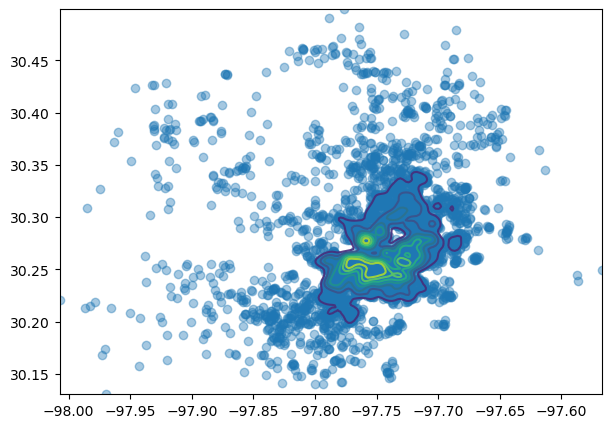

In [50]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))


ax.scatter(lst.longitude, lst.latitude, alpha=0.4)
ax.contour(
    xx, yy, densidad_pred.reshape(xx.shape),
    alpha =0.9
)

Notemos que con los anchos de banda estimados por validación cruzada tenemos dentro del centro distintos puntos de calor que distinguen las áreas geográficas.

Veamos ahora estos resultados sobre un mapa interactivo usando `folium`. Para ello primero tenemos que pasar las curvas de nivel a `geojson`

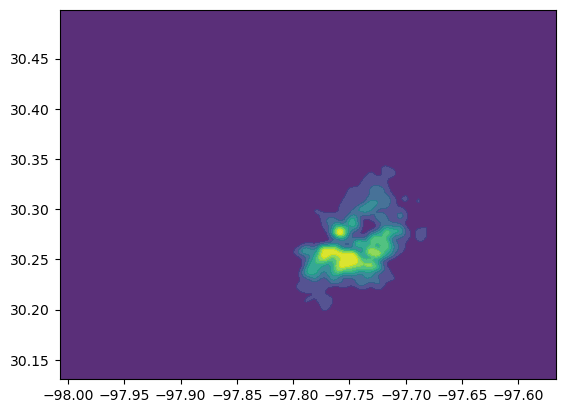

In [51]:
import geojsoncontour

contourf = plt.contourf(xx, yy, densidad_pred.reshape(xx.shape),
    alpha =0.9, linestyles='None')
                        
geojson = geojsoncontour.contourf_to_geojson(
    contourf=contourf,
    min_angle_deg=3.0,
    ndigits=5,
    stroke_width=1,
    fill_opacity=0.1)

Con ello estamos en condiciones de usar `folium`:

In [52]:
import folium
                        
map = folium.Map([lst.latitude.mean(), lst.longitude.mean()], zoom_start=12, tiles="OpenStreetMap")# Plot the contour on Folium map
folium.GeoJson(
    geojson,
    style_function=lambda x: {
        'color':     x['properties']['stroke'],
        'weight':    x['properties']['stroke-width'],
        'fillColor': '#FFFFFF',
        'lineColor': '#FFFFFF',
        'opacity':   0.5,
    }).add_to(map)

map

El mapa interactivo nos permite ver además del punto caliente central, también nos permite ver por ejemplo dos puntos calientes pequeños: uno ubicado alrededor del parque "West Austin" en Clarksville y otro al sur de East Cesar Chavez Street entre Waller Street y Antony Street. 

Tener disponibles estas densidades tiene la ventaja adicional que nos permite calcular la probabilidad de encontrar un Airbnb en un area dada $P(a\leq long \leq b, c \leq lat \leq d)=\int_a^b \int_c^d \hat{f}(lat,long) \times d(lat) \times d(long)$.

Para profundizar el análisis podemos también usar información de los códigos postales (*zipcodes*) para identificar aquellos lugares con más densidad. Para verlo comencemos transformando los datos en un `GeoDataFrame`:

In [53]:
db = pd.DataFrame(grid)

In [54]:
db.columns = ['latitude','longitude']
db['densidad_pred'] = densidad_pred
db = gpd.GeoDataFrame(db, geometry = gpd.points_from_xy(db.longitude, db.latitude))
db.crs = "EPSG:4326"
db.head()

,latitude,longitude,densidad_pred,geometry
0,30.130516,-98.007324,9.195753e-21,POINT (-98.00732 30.13052)
1,30.130516,-98.005112,1.886968e-18,POINT (-98.00511 30.13052)
2,30.130516,-98.002899,2.807604e-16,POINT (-98.0029 30.13052)
3,30.130516,-98.000687,3.029010e-14,POINT (-98.00069 30.13052)
4,30.130516,-97.998474,2.369515e-12,POINT (-97.99847 30.13052)


Luego cargamos los mapas con los códigos postales (*zipcodes*) de la carpeta de datos: 

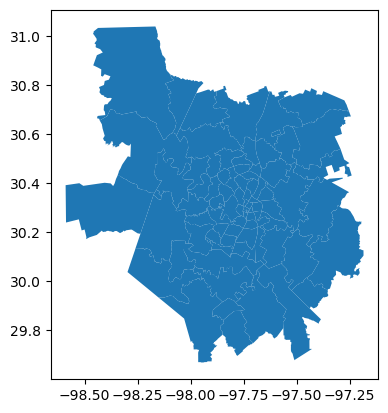

In [55]:
zc = gpd.read_file('data/Zipcodes.geojson')
zc.plot();

Hacemos la unión espacial:

In [56]:
union = gpd.sjoin(db, zc)
union.head()

,latitude,longitude,densidad_pred,geometry,index_right,created_by,modified_b,zipcode,name,shape_area,created_da,objectid,geodb_oid,modified_d,shape_len,zipcodes_i
0,30.130516,-98.007324,9.195753e-21,POINT (-98.00732 30.13052),5,,,78737,AUSTIN,1320054161.47,,6,6,,206132.564319437,59
1,30.130516,-98.005112,1.886968e-18,POINT (-98.00511 30.13052),5,,,78737,AUSTIN,1320054161.47,,6,6,,206132.564319437,59
2,30.130516,-98.002899,2.807604e-16,POINT (-98.0029 30.13052),5,,,78737,AUSTIN,1320054161.47,,6,6,,206132.564319437,59
3,30.130516,-98.000687,3.029010e-14,POINT (-98.00069 30.13052),5,,,78737,AUSTIN,1320054161.47,,6,6,,206132.564319437,59
4,30.130516,-97.998474,2.369515e-12,POINT (-97.99847 30.13052),5,,,78737,AUSTIN,1320054161.47,,6,6,,206132.564319437,59


Luego agregamos la densidad a nivel de códigos postales (*zipcodes*) y las ordenamos de mayor a menor:

In [57]:
sum_pred=union.groupby('zipcode')[['densidad_pred']].sum()
sum_pred.sort_values(by=['densidad_pred'], ascending=False).head()

,densidad_pred
zipcode,
78704,65440.032436
78702,31152.903426
78703,16993.523928
78741,16657.465879
78745,14157.646501


Finalmente agregamos a nuestro mapa de calor los códigos postales (*zipcodes*) con mayor densidad. Notemos que estos coinciden con la ubicación de los puntos calientes:

In [58]:
df = zc[zc.zipcode.isin(["78704","78702","78703"])]

for _, r in df.iterrows():
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    folium.Popup(r['zipcode']).add_to(geo_j)
    geo_j.add_to(map)

map

## Consideraciones Finales

En este cuaderno exploramos la detección de puntos calientes a través de estimación de densidades bivariadas. Es importante resaltar que estas estimaciones  pueden aplicarse a cualquier tipo de datos y no está limitado necesariamente a datos geográficos, ni a dos dimensiones.  Sin embargo cuando uno estima densidades de más de dos dimensiones los resultados tienden a empeorar, debido a que la información disponible para estimar se vuelve más escasa, esto se conoce como el problema de la [maldición de la dimensionalidad](https://es.wikipedia.org/wiki/Maldici%C3%B3n_de_la_dimensi%C3%B3n) y los invito a que exploren un poco más sobre ella.

# Referencias

- Amat Rodrigo, J. Ajuste de distribuciones con kernel density estimation y Python. Disponible en https://www.cienciadedatos.net/documentos/pystats02-ajuste-distribuciones-kde-python.html. Accedido el 10/04/2022 

- Azzalini, A. and Bowman, A. W. (1990). A look at some data on the Old Faithful geyser. Applied Statistics, 39, 357–365. doi: 10.2307/2347385. 

- Cottam, J., Lumsdaine, A., & Wang, P. (2014). Abstract rendering: Out-of-core rendering for information visualization. Proceedings of SPIE - The International Society for Optical Engineering. 9017. 90170K. 10.1117/12.2041200

- Jones, Aaron; Kruger, Christopher; Johnston, Benjamin. The Unsupervised Learning Workshop: Get started with unsupervised learning algorithms and simplify your unorganized data to help make future predictions. Packt Publishing. Kindle Edition. 

- Li, Q., and Racine, J. S. (2007). Nonparametric econometrics: theory and practice. Princeton University Press.

- Pagan, A. and Ullah (1999). Nonparametric Econometrics. Cambridge University Press.
  
- Silverman (1998). Density Estimation for Statistics and Data Analysis. Chapman & Hall/CRC.

- Rey, S., & Arribas-Bel, D. (nd). Introduction Geographic Data Science with PySAL and the pydata stack

# Información de Sesión

In [59]:
import session_info

session_info.show(html=False)

-----
bokeh               3.4.1
folium              0.17.0
geojsoncontour      NA
geopandas           1.0.1
ipykernel           6.28.0
ipywidgets          7.8.1
matplotlib          3.8.4
numpy               1.26.4
pandas              2.2.2
scipy               1.12.0
seaborn             0.13.2
session_info        1.0.0
sklearn             1.4.2
statsmodels         0.14.2
xarray              2023.6.0
-----
IPython             8.25.0
jupyter_client      8.6.0
jupyter_core        5.7.2
jupyterlab          4.0.11
notebook            7.0.8
-----
Python 3.12.4 | packaged by Anaconda, Inc. | (main, Jun 18 2024, 15:03:56) [MSC v.1929 64 bit (AMD64)]
Windows-11-10.0.22631-SP0
-----
Session information updated at 2024-09-30 09:53


In [2]:
!pip install mysql-connector-python

   ---------------------------------------- 0.0/16.1 MB ? eta -:--:--
    --------------------------------------- 0.3/16.1 MB ? eta -:--:--
   - -------------------------------------- 0.8/16.1 MB 2.1 MB/s eta 0:00:08
   --- ------------------------------------ 1.3/16.1 MB 2.2 MB/s eta 0:00:07
   --- ------------------------------------ 1.6/16.1 MB 2.1 MB/s eta 0:00:07
   ---- ----------------------------------- 1.8/16.1 MB 2.1 MB/s eta 0:00:07
   ----- ---------------------------------- 2.4/16.1 MB 1.9 MB/s eta 0:00:08
   ------ --------------------------------- 2.6/16.1 MB 1.9 MB/s eta 0:00:08
   ------- -------------------------------- 3.1/16.1 MB 1.9 MB/s eta 0:00:07
   -------- ------------------------------- 3.4/16.1 MB 1.8 MB/s eta 0:00:07
   --------- ------------------------------ 3.7/16.1 MB 1.8 MB/s eta 0:00:07
   ---------- ----------------------------- 4.2/16.1 MB 1.8 MB/s eta 0:00:07
   ----------- ---------------------------- 4.5/16.1 MB 1.8 MB/s eta 0:00:07
   ----------